In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

import cv2 as cv
from scipy import ndimage as ndi

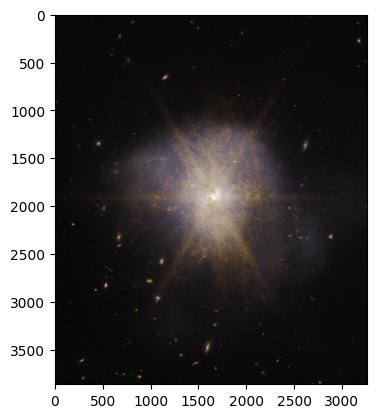

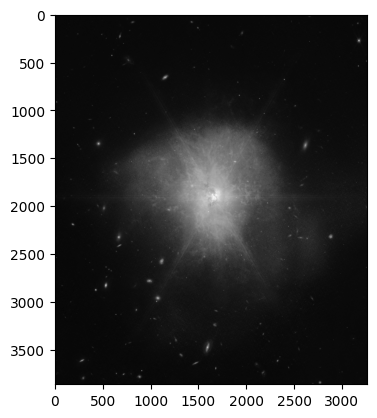

In [2]:
# criando o path de ler imagem, localizado em tests/data/galaxy

current_path = os.getcwd()
# subindo uma folder para acessar a pasta data
current_path = os.path.abspath(os.path.join(current_path, os.pardir))
img_path = "data/galaxy/arp220.tif"

path = os.path.join(current_path, img_path)

# lendo a imagem 'quintet.tif'
img = tiff.imread(path)

img_array = np.array(img)

gray = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)

plt.imshow(img_array)
plt.show()

plt.imshow(gray, cmap="gray")
plt.show()

In [3]:
h, w = gray.shape
print(h, w)

3864 3267


## pronto para aplicar a transformada de fourier

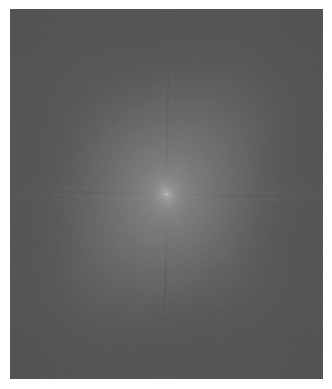

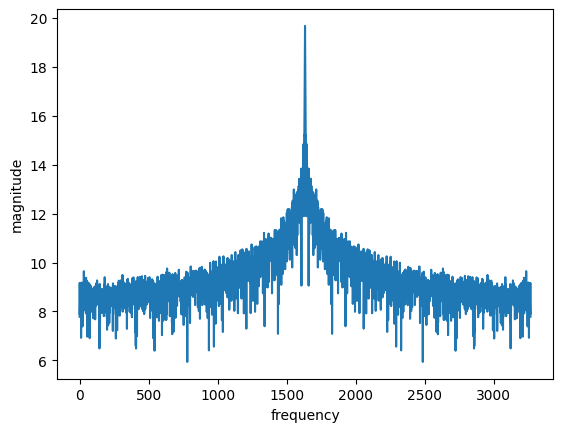

In [4]:
img_copy = gray.copy()

f_transform = np.fft.fft2(img_copy)
f_transform = np.fft.fftshift(f_transform)

magnitude_spectrum = np.abs(f_transform)
magnitude_spectrum = np.log(1+magnitude_spectrum)

height, width = magnitude_spectrum.shape
horizontal_profile = magnitude_spectrum[height//2, :]

plt.imshow(magnitude_spectrum, cmap='gray')
plt.axis('off')
plt.show()

plt.plot(horizontal_profile)
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.show()

In [5]:
max(horizontal_profile)

19.662917866731938

In [6]:
min(horizontal_profile)

5.940769870766988

In [7]:
magnitude_spectrum.min()

1.080450013105729

In [8]:
magnitude_spectrum.max()

19.662917866731938

## fazendo filtro passa banda

In [71]:
def filter_image(img, fmax, fmin, dpi, img_show_tuple, plt_show_tuple, subplot_tuple):
    img_array = np.array(img)

    # Plot the input image, colored
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(img_array)
    plt.axis("off")

    # Convert to grayscale
    gray = cv.cvtColor(img_array, cv.COLOR_BGR2GRAY)

    # Plot the grayscale image
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(gray, cmap="gray")
    plt.axis("off")

    # Starting the pipeline
    f_transform = np.fft.fft2(gray)
    f_transform = np.fft.fftshift(f_transform)

    magnitude_spectrum = np.abs(f_transform)
    magnitude_spectrum = np.log(1 + magnitude_spectrum)

    # Plotting with matplotlib
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(magnitude_spectrum, cmap="gray")
    plt.axis("off")
    plt.show()

    height, _ = magnitude_spectrum.shape
    horizontal_profile = magnitude_spectrum[height // 2, :]

    # Plot the horizontal profile as a line plot
    plt.figure(figsize=plt_show_tuple, dpi=dpi)
    plt.plot(horizontal_profile)
    plt.xlabel("frequency")
    plt.ylabel("magnitude")
    plt.show()

    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2

    mask = magnitude_spectrum.copy()

    l, c = np.indices((rows, cols))
    distances = np.sqrt((l - crow) ** 2 + (c - ccol) ** 2)
    mask = np.where((distances > fmax) | (distances < fmin), 0, mask)

    # Applying Gaussian smoothing to the mask
    mask = ndi.gaussian_filter(mask, sigma=5)

    # Plotting the mask
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(np.abs(mask), cmap="gray")
    plt.axis("off")
    plt.show()

    # Apply the mask
    f_transform *= mask

    # Inverse FFT
    f_ishift = np.fft.ifftshift(f_transform)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    # Plotting the image back
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(img_back, cmap="gray")
    plt.axis("off")
    plt.show()

    # Apply the Sobel filter
    dx = ndi.sobel(img_back, 0)
    dy = ndi.sobel(img_back, 1)
    mag = np.hypot(dx, dy)
    mag *= 255.0 / np.max(mag)

    # Plotting the Sobel filter
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(mag, cmap="gray")
    plt.axis("off")
    plt.show()

    # Blend the Sobel output with the original image
    sobel = np.zeros((rows, cols, 3), dtype=np.uint8)
    sobel[:, :, 0] = mag
    sobel[:, :, 1] = mag
    sobel[:, :, 2] = mag

    img_array = img_array.astype(np.uint8)

    blend = cv.addWeighted(img_array, 0.7, sobel, 0.3, 0)

    # Plotting the blended image
    plt.figure(figsize=img_show_tuple, dpi=dpi)
    plt.imshow(blend)
    plt.axis("off")
    plt.show()

    # Subplot to compare the final image with the original
    plt.figure(figsize=subplot_tuple, dpi=dpi)
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blend)
    plt.axis("off")
    plt.show()

    return None

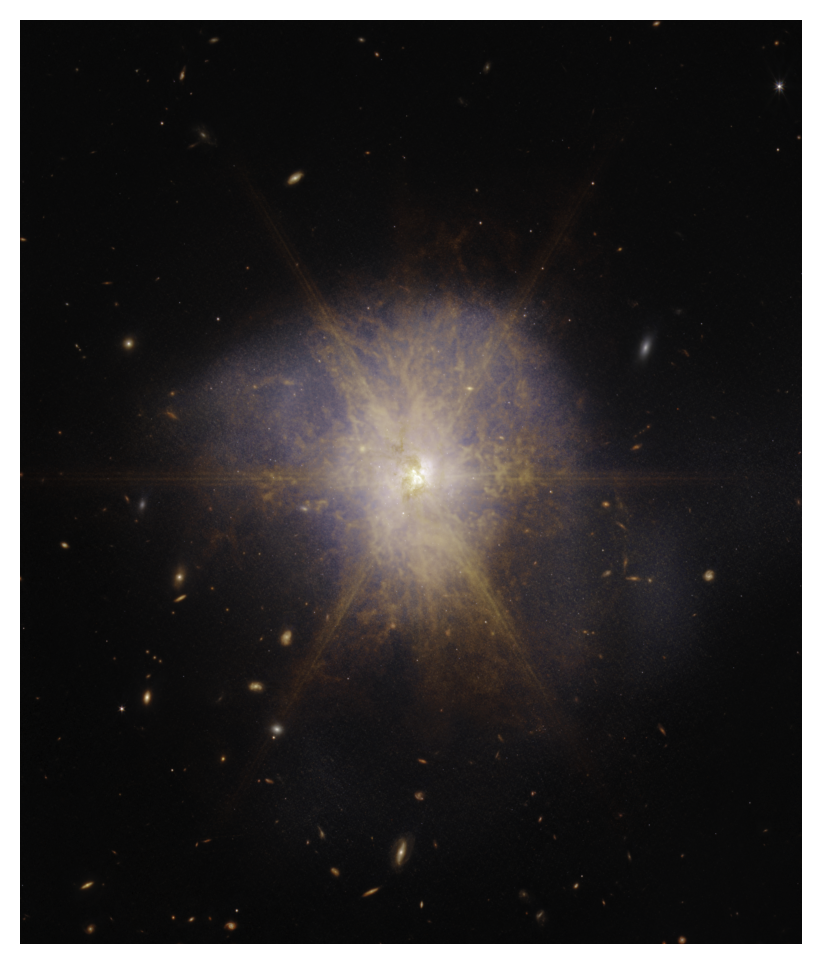

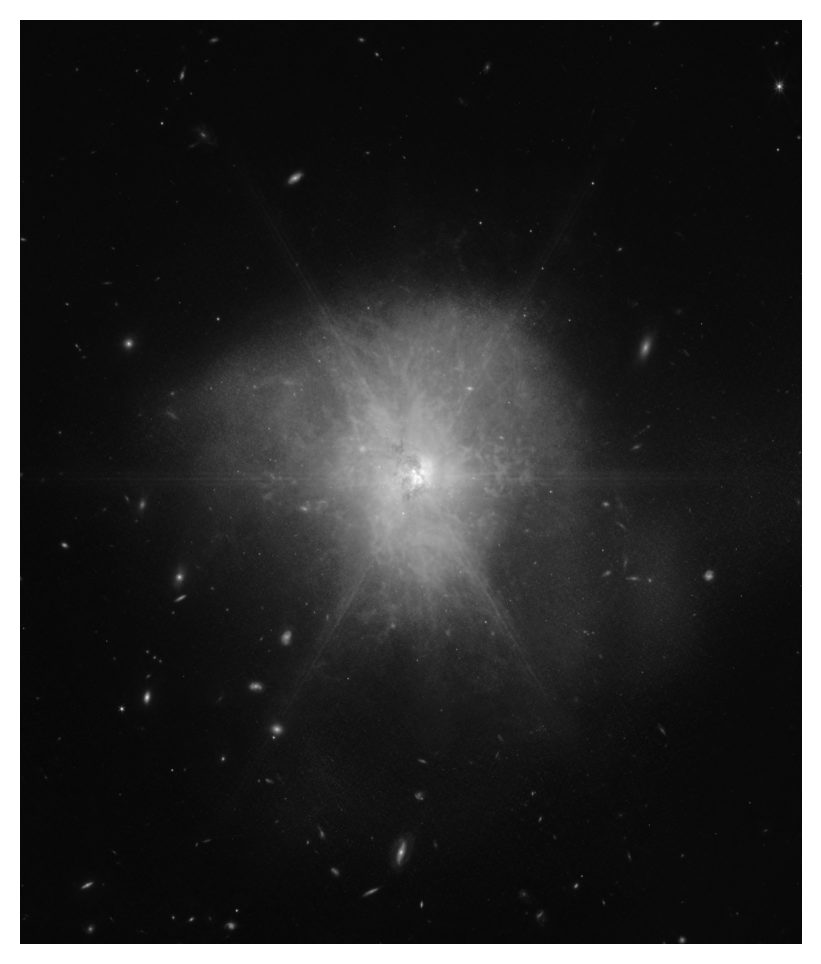

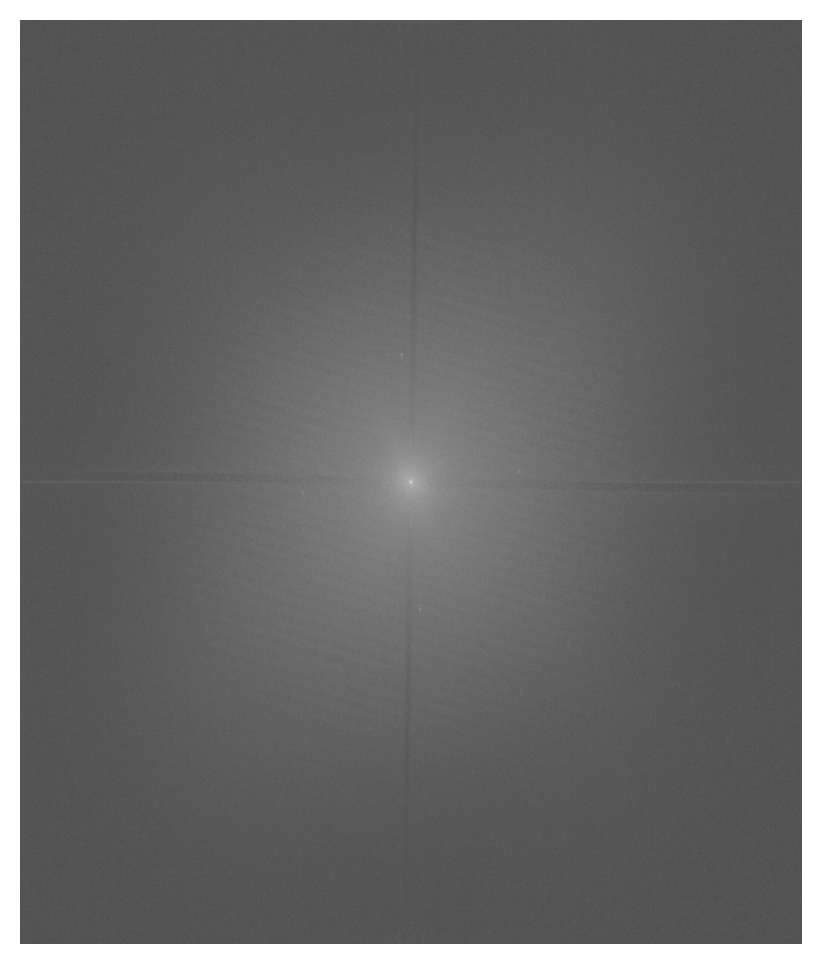

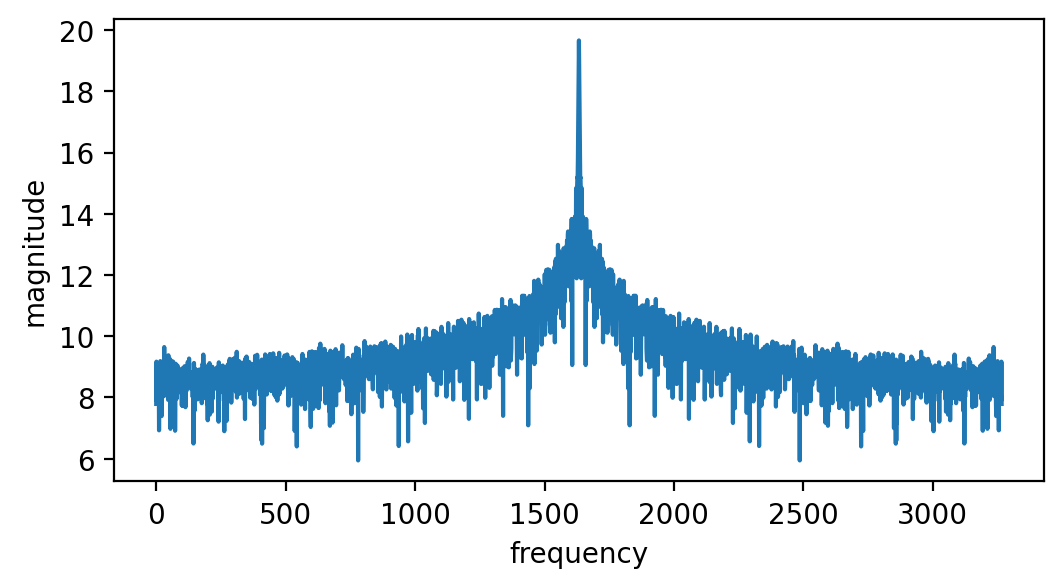

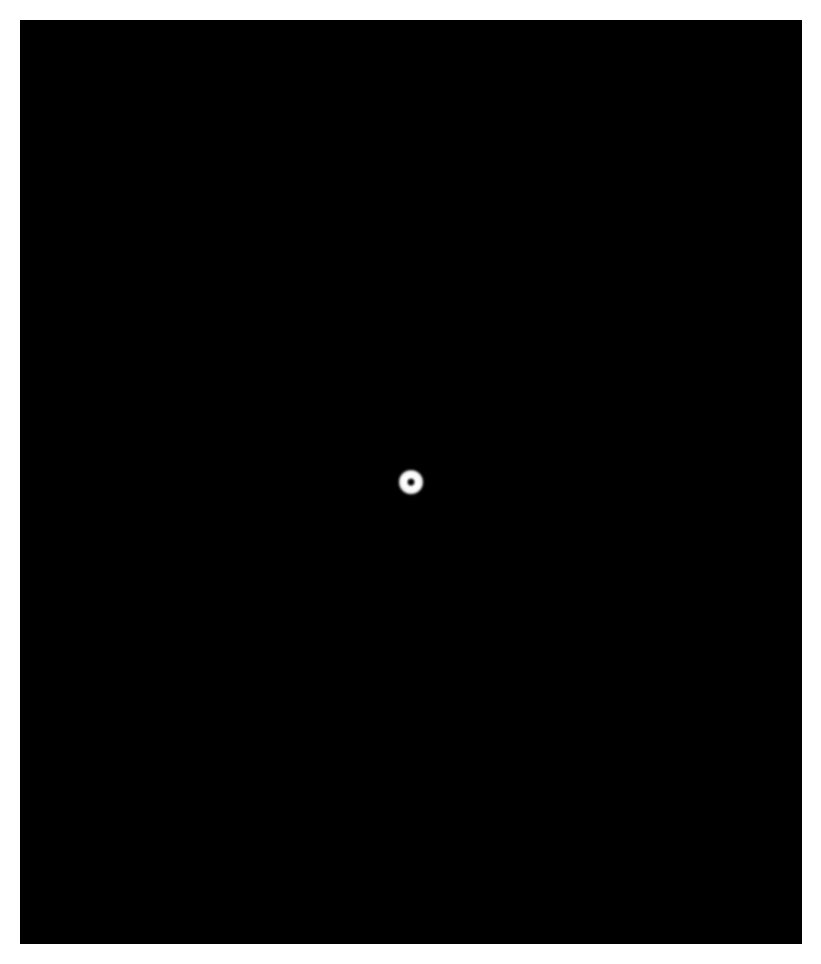

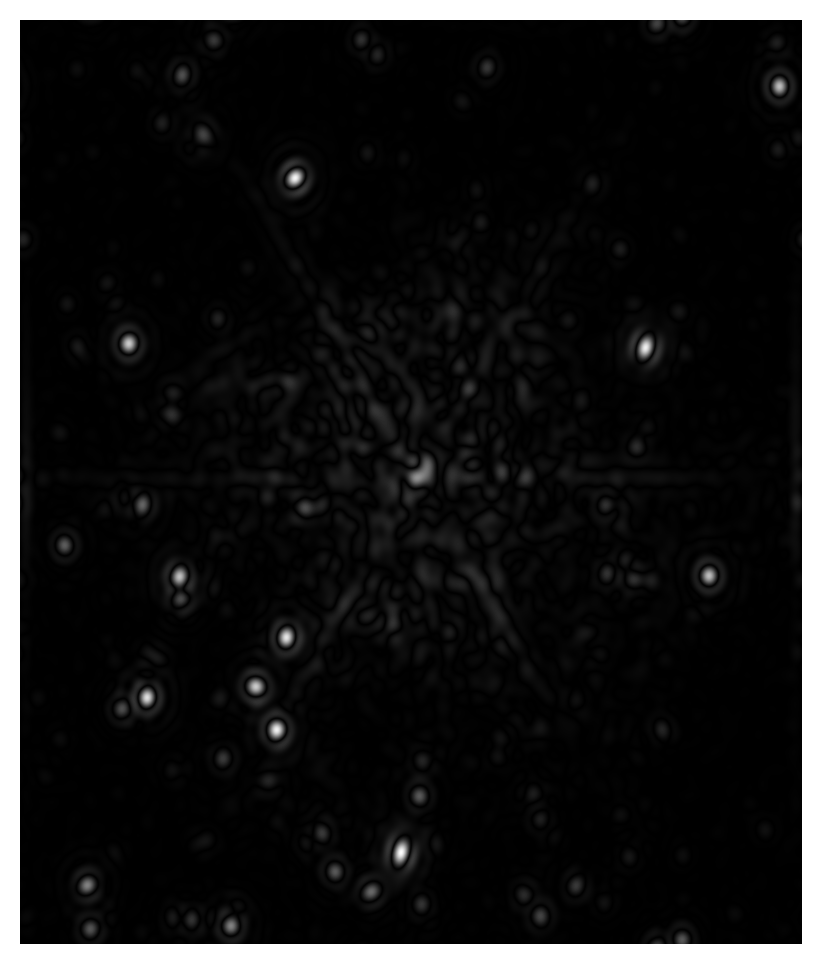

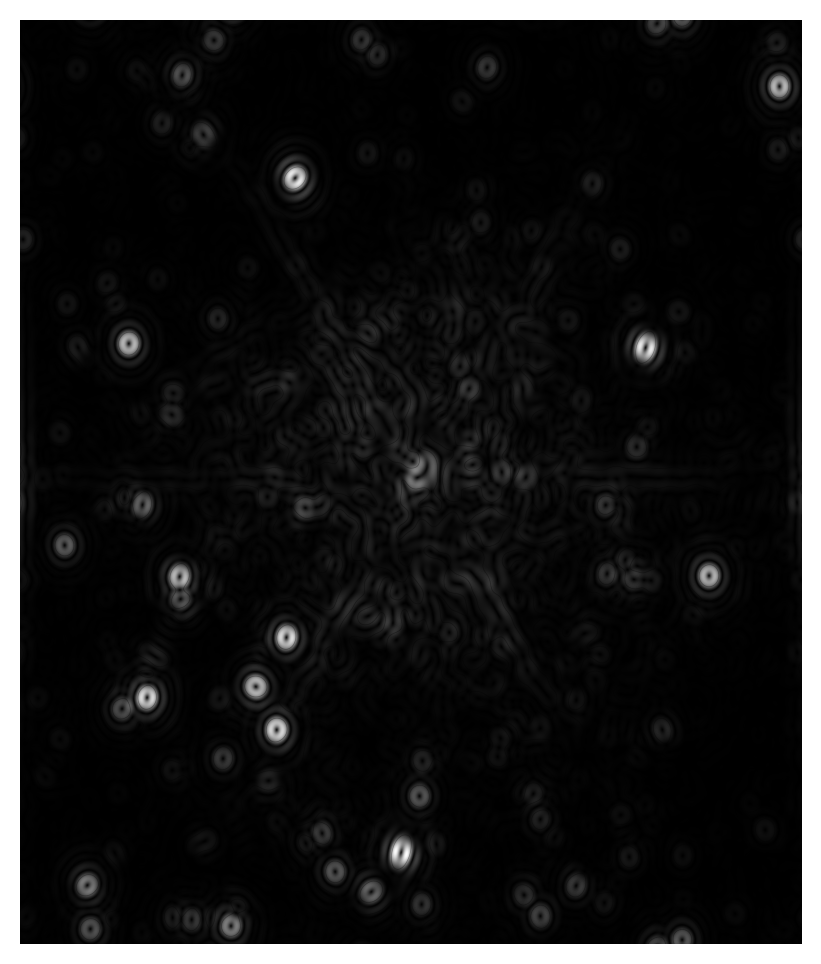

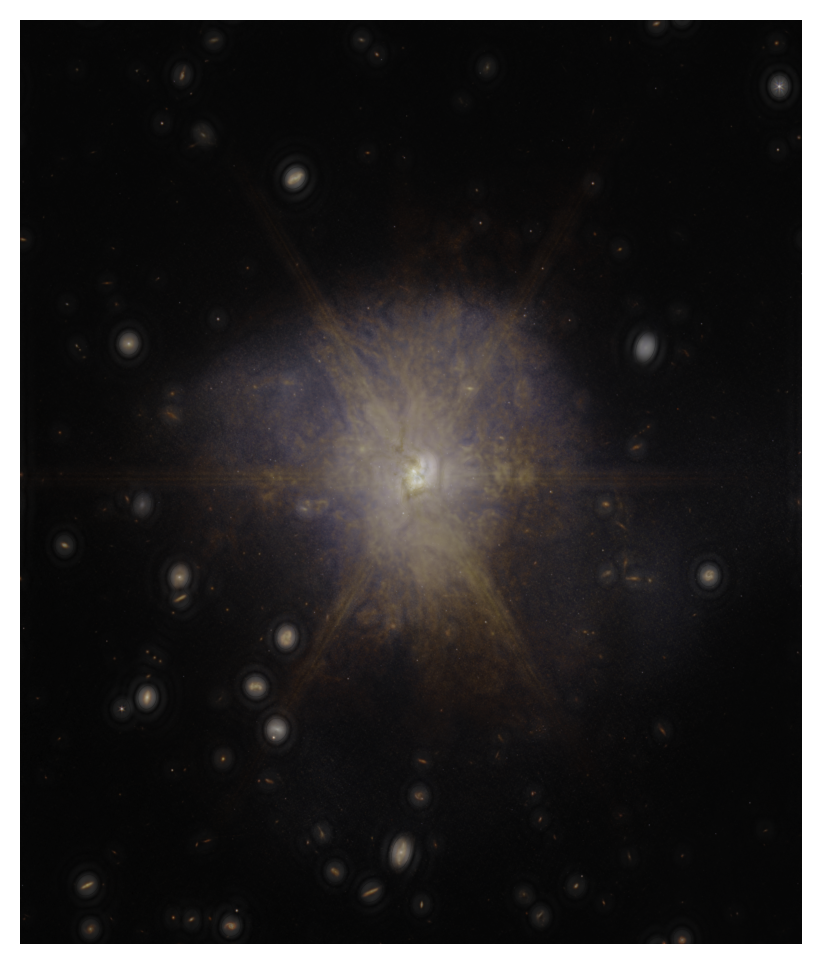

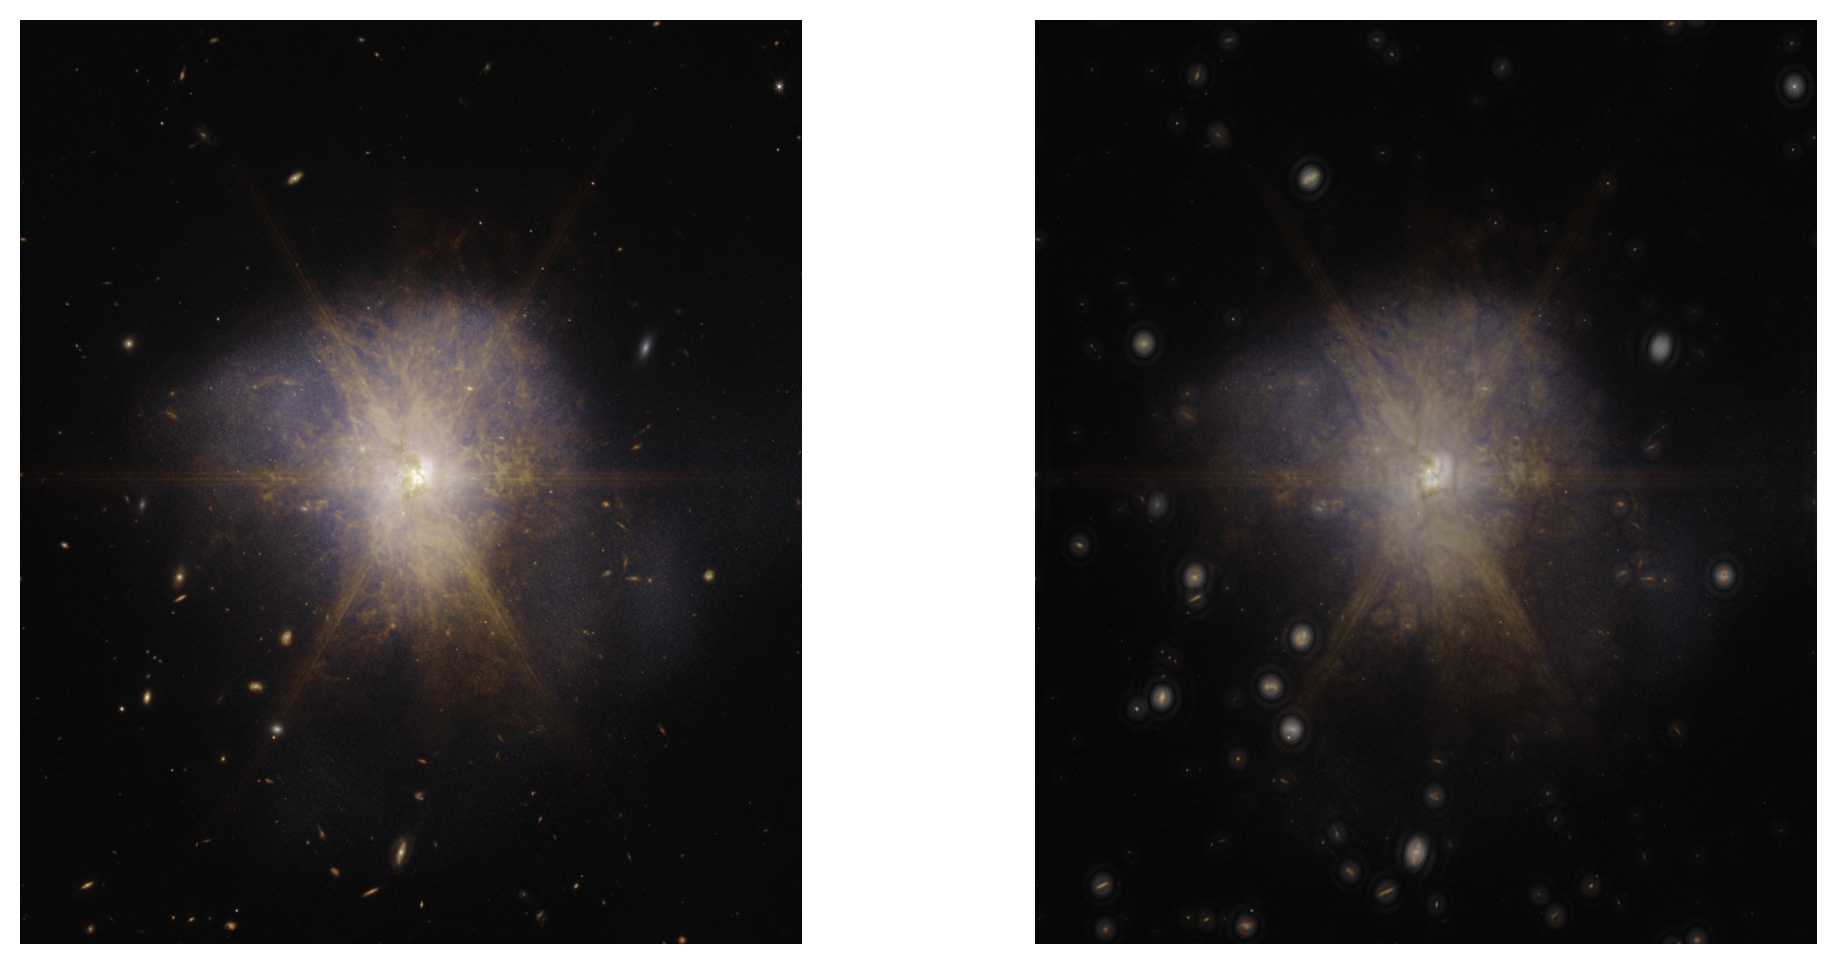

In [74]:
filter_image(img, fmax=50, fmin=15, dpi=200, img_show_tuple=(6, 6), plt_show_tuple=(6, 3), subplot_tuple=(12, 6))

## voltando para imagem original

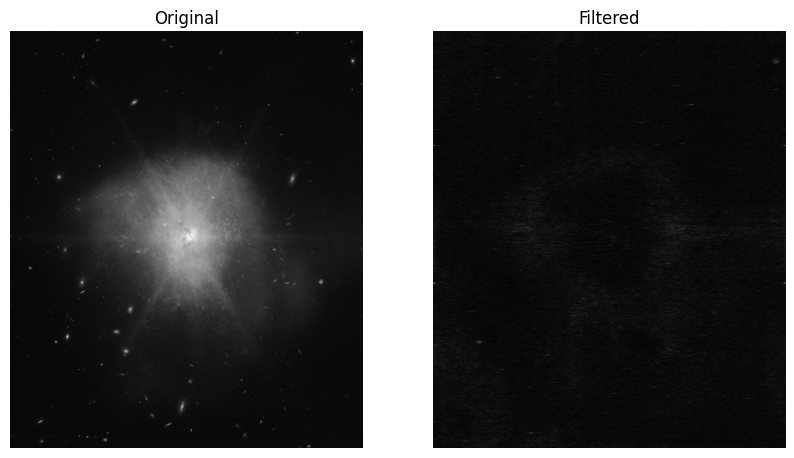

In [30]:
# agora, com a transformada inversa, vamos voltar para o dominio espacial

f_transform_filtered = np.fft.ifftshift(f_transform_filtered)

img_back = np.fft.ifft2(f_transform_filtered)

img_back = np.abs(img_back)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(img_back, cmap='gray')
plt.axis('off')
plt.title('Filtered')

plt.show()

## aplicando sobel na imagem fitlrada

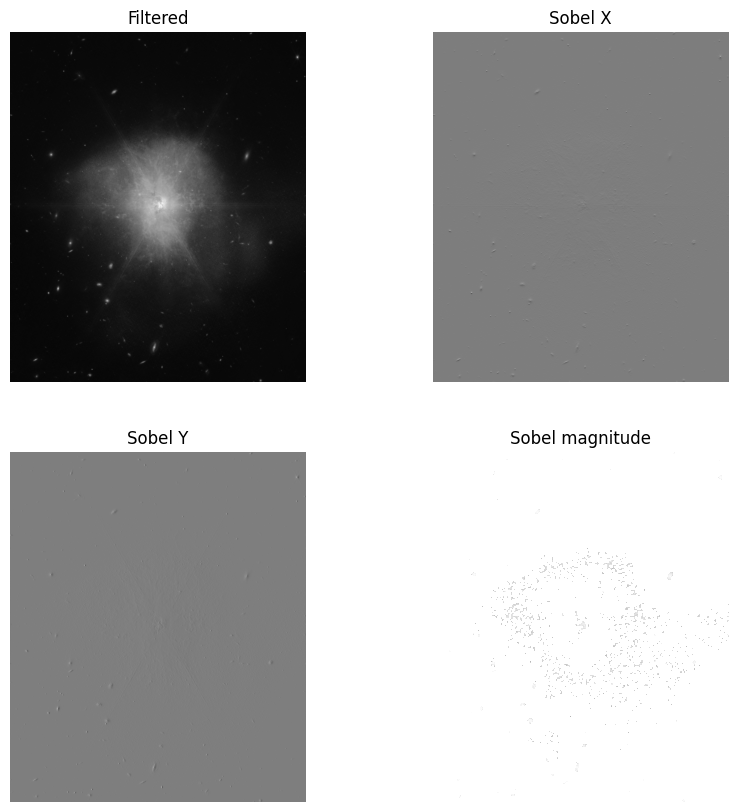

In [28]:
# sobel em cima da imagem filtrada

img_back_int = img_back.astype('int32')

sobel_x = ndi.sobel(img_back_int, axis=0)
sobel_y = ndi.sobel(img_back_int, axis=1)

magnitude_sobel = np.hypot(sobel_x, sobel_y)

# normalizando a magnitude do sobel

magnitude_sobel *= 255.0 / np.max(magnitude_sobel)

#invertendo a imagem
magnitude_sobel = cv.bitwise_not(magnitude_sobel)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(img_back_int, cmap='gray')
plt.axis('off')
plt.title('Filtered')

plt.subplot(2, 2, 2)
plt.imshow(sobel_x, cmap='gray')
plt.axis('off')
plt.title('Sobel X')

plt.subplot(2, 2, 3)
plt.imshow(sobel_y, cmap='gray')
plt.axis('off')
plt.title('Sobel Y')

plt.subplot(2, 2, 4)
plt.imshow(magnitude_sobel, cmap='gray')
plt.axis('off')
plt.title('Sobel magnitude')

plt.show()